In [62]:
# Political Pole Detector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# This helps turn .txt files into Excel files .xlsx or CSV files (if you're lucky)
# If files aren't cooperative...run this code then copy and paste the dates into column one
# and articles into column two in Excel, then save as an Excel file.

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            date = line
#            date = date[0:12]
#            with open('csvs/NewsMax.txt', 'a+', encoding='utf-8') as s:
#                s.write(date + "\n")

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            article = line
#            article = article[12:]
#            with open('csvs/NewsMax2.txt', 'a+', encoding='utf-8') as s:
#                s.write(article)

In [64]:
# Let's see what features we have.

# Character length requirement for articles
length_req = 800

left = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left.shape[0]))

for x in range(left.shape[0]):
    if len(left['article'][x]) < length_req:
        left.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left.shape[0], length_req))

# Only keep the unique article rows and their values
left.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left.shape[0]))

left['date'] = left['date'].str.replace(',', '')

left.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [65]:
# Let's see what features we have.
right = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right.shape[0]))

#count = right.shape[0]

for x in range(right.shape[0]):
    if len(right['article'][x]) < length_req:
        right.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right.shape[0], length_req))

# Only keep the unique rows and their values
right.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right.shape[0]))

right['date'] = right['date'].str.replace(',', '')

right.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [66]:
# Check for null values
right.isnull().sum(axis=0)

date       15
article     0
dtype: int64

In [67]:
left.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [68]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [69]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [70]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)

all_data = pd.concat([left, right]) # combine left and right datasets
column_names = all_data.columns.values
all_data.columns = column_names
all_data = all_data.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data['date'] = all_data['date'].str.replace(',', '')
all_data.head()

We have 4,304 left-wing records
We have 5,588 right-wing records
Getting random sample of right-wing records


,date,article,pole
0,2020-01-24,Early Voting Means 2020 Primary Is Already Her...,0
1,2020-03-05,Sen. Graham: No Need to Censure Schumer Sen. L...,1
2,2020-02-03,Iowa Caucuses Results Delayed for 'Quality Che...,1
3,2020-04-23,State Dept.'s Ortagus: 'Transparency' Needed F...,1
4,2020-02-22,Warren Leaving Nevada For Seattle Before Caucu...,1


In [71]:
print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

# Only keep the unique rows and their values
all_data.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

4,304 / 8,608 Current Records
8,608 Records are unique
4,304 / 8,608 Current Records


In [72]:
# Save the rows used from notspam to a CSV.
# Can give you a good idea of what constitutes a good set of data
# when a run results in high accuracy.
#notspam.to_csv(r'positive.csv')
#spam.to_csv(r'negative.csv')

# We can see there's some strange html characters present.
# Very important to cast the entire column as a string type first, so some of these numeric values come in as strings.
# Otherwise, the row values for these comments where they're present will turn into NaN values.
#all_data['article'] = all_data['article'].astype(str).str.replace(r'&#39;', "\'").astype('string')

# This is a more clean and thorough url decoding function for decoding any character string...
all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))

In [73]:
# Store the original comments in a new column
all_data['unfiltered_articles'] = all_data['article'].values
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-01-24,Early Voting Means 2020 Primary Is Already Her...,0,Early Voting Means 2020 Primary Is Already Her...
1,2020-03-05,Sen. Graham: No Need to Censure Schumer Sen. L...,1,Sen. Graham: No Need to Censure Schumer Sen. L...
2,2020-02-03,Iowa Caucuses Results Delayed for 'Quality Che...,1,Iowa Caucuses Results Delayed for 'Quality Che...
3,2020-04-23,State Dept.'s Ortagus: 'Transparency' Needed F...,1,State Dept.'s Ortagus: 'Transparency' Needed F...
4,2020-02-22,Warren Leaving Nevada For Seattle Before Caucu...,1,Warren Leaving Nevada For Seattle Before Caucu...


In [74]:
# Proper Noun Removal
# Do this before lowercasing all text
from nltk.tag import pos_tag

def proper_noun_removal(text):
    tagged_sent = pos_tag(text.split())
    return [w for w, pos in tagged_sent if pos != 'NNP']
    
all_data['article'] = all_data['article'].apply(proper_noun_removal)

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-01-24,Early Voting Means 2020 Here For of the 14 sta...,0,Early Voting Means 2020 Primary Is Already Her...
1,2020-03-05,to Censure says there is no need to censure fo...,1,Sen. Graham: No Need to Censure Schumer Sen. L...
2,2020-02-03,for Democrats were beginning to worry late bec...,1,Iowa Caucuses Results Delayed for 'Quality Che...
3,2020-04-23,'Transparency' Needed From on The world won't ...,1,State Dept.'s Ortagus: 'Transparency' Needed F...
4,2020-02-22,For will leave before the results of the caucu...,1,Warren Leaving Nevada For Seattle Before Caucu...


In [75]:
# Checks to make sure proper nouns were removed
#all_data['article'][0]
#all_data['unfiltered_articles'][0]

In [76]:
# Clean the text
# The apostrophes here are very specific.
# The regular ' will not work from keyboard.
# You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
all_data['article'] = all_data['article'].str.lower()
all_data['article'] = all_data['article'].str.replace(r"u.s.", "united states")
all_data['article'] = all_data['article'].str.replace(r"what’s", "what is")
all_data['article'] = all_data['article'].str.replace(r"’s", " ")
all_data['article'] = all_data['article'].str.replace(r"’ve", "have")
all_data['article'] = all_data['article'].str.replace(r"’re", "are")
all_data['article'] = all_data['article'].str.replace(r"’ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can’t", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren’t", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn’t", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn’t", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn’t", "does not")
all_data['article'] = all_data['article'].str.replace(r"don’t", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn’t", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn’t", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven’t", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn’t", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn’t", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn’t", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren’t", "were not")
all_data['article'] = all_data['article'].str.replace(r"won’t", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn’t", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn’t", "must not")
all_data['article'] = all_data['article'].str.replace(r"i’m", "i am")

# As are these apostrophes...
all_data['article'] = all_data['article'].str.replace(r"what's", "what is")
all_data['article'] = all_data['article'].str.replace(r"'s", " ")
all_data['article'] = all_data['article'].str.replace(r"'ve", "have")
all_data['article'] = all_data['article'].str.replace(r"'re", "are")
all_data['article'] = all_data['article'].str.replace(r"'ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can't", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren't", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn't", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn't", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn't", "does not")
all_data['article'] = all_data['article'].str.replace(r"don't", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn't", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn't", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven't", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn't", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn't", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn't", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren't", "were not")
all_data['article'] = all_data['article'].str.replace(r"won't", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn't", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn't", "must not")
all_data['article'] = all_data['article'].str.replace(r"i'm", "i am")
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-01-24,early voting means 2020 here for of the 14 sta...,0,Early Voting Means 2020 Primary Is Already Her...
1,2020-03-05,to censure says there is no need to censure fo...,1,Sen. Graham: No Need to Censure Schumer Sen. L...
2,2020-02-03,for democrats were beginning to worry late bec...,1,Iowa Caucuses Results Delayed for 'Quality Che...
3,2020-04-23,'transparency' needed from on the world will n...,1,State Dept.'s Ortagus: 'Transparency' Needed F...
4,2020-02-22,for will leave before the results of the caucu...,1,Warren Leaving Nevada For Seattle Before Caucu...


In [77]:
# Custom word removal - these appear too frequently and do not help with generalization.
custom = {'donald j trump', 'donald john trump', 'donald j. trump', 'newsmax', "huffpost", "___", "donald trump", "trump", "pelosi"}

# Did not work
#for word in custom:
#    all_data["article"]= all_data["article"].replace(word, " ") 

# Did not work
#all_data['article'] = all_data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

# Did work
#def customWord(text):
#    custom = {'donald j trump', 'donald john trump', 'donald j. trump', "huffpost", "newsmax"}
#    return text.replace("huffpost", " ") 

for word in custom:
    all_data['article'] = all_data['article'].apply(lambda x: x.replace(word, " "))
    
# Check to see the words were replaced
all_data[all_data['article'].str.contains("newsmax")]

,date,article,pole,unfiltered_articles


In [78]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

all_data['article'] = all_data['article'].apply(lambda x: remove_years(x))
all_data.head()

# Punctuation removal - CountVectorizer() does this for you
#punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

,date,article,pole,unfiltered_articles
0,2020-01-24,early voting means here for of the states ...,0,Early Voting Means 2020 Primary Is Already Her...
1,2020-03-05,to censure says there is no need to censure fo...,1,Sen. Graham: No Need to Censure Schumer Sen. L...
2,2020-02-03,for democrats were beginning to worry late bec...,1,Iowa Caucuses Results Delayed for 'Quality Che...
3,2020-04-23,'transparency' needed from on the world will n...,1,State Dept.'s Ortagus: 'Transparency' Needed F...
4,2020-02-22,for will leave before the results of the caucu...,1,Warren Leaving Nevada For Seattle Before Caucu...


In [79]:
all_data[all_data['article'].str.contains("19")]

,date,article,pole,unfiltered_articles


### One-gram - Stopword removal and no lemmatization

In [80]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.733759
704953.6812999977ms
Confusion Matrix:
[[715 169]
 [266 572]]
Accuracy Score : 0.7473867595818815
Report : 
              precision    recall  f1-score   support

        Left       0.73      0.81      0.77       884
       Right       0.77      0.68      0.72       838

    accuracy                           0.75      1722
   macro avg       0.75      0.75      0.75      1722
weighted avg       0.75      0.75      0.75      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.801471
338008.07879999775ms
Confusion Matrix:
[[694 177]
 [179 672]]
Accuracy Score : 0.7932636469221835
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.80      0.80       871
       Right       0.79      0.79      0.79       851

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

LinearS

### Voteclassifier - Stopword removal and no lemmatization

In [81]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.817344
1520519.4991000025ms
Confusion Matrix:
[[714 129]
 [180 699]]
Accuracy Score : 0.8205574912891986
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.85      0.82       843
       Right       0.84      0.80      0.82       879

    accuracy                           0.82      1722
   macro avg       0.82      0.82      0.82      1722
weighted avg       0.82      0.82      0.82      1722



In [82]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [83]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [84]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_onegram_sr_nol_pr.pkl')

['h_and_n_onegram_sr_nol_pr.pkl']

### Bi-gram - Stopword removal and no lemmatization

In [85]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.739876
1334451.6683000003ms
Confusion Matrix:
[[665 190]
 [267 600]]
Accuracy Score : 0.7346109175377468
Report : 
              precision    recall  f1-score   support

        Left       0.71      0.78      0.74       855
       Right       0.76      0.69      0.72       867

    accuracy                           0.73      1722
   macro avg       0.74      0.73      0.73      1722
weighted avg       0.74      0.73      0.73      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.808614
697753.5838000004ms
Confusion Matrix:
[[724 129]
 [204 665]]
Accuracy Score : 0.8066202090592335
Report : 
              precision    recall  f1-score   support

        Left       0.78      0.85      0.81       853
       Right       0.84      0.77      0.80       869

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

LinearS

### Voteclassifier - Stopword removal and no lemmatization

In [86]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.819957
1833764.7299000018ms
Confusion Matrix:
[[742 106]
 [227 647]]
Accuracy Score : 0.8066202090592335
Report : 
              precision    recall  f1-score   support

        Left       0.77      0.88      0.82       848
       Right       0.86      0.74      0.80       874

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722



In [87]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [88]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [89]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_bigram_sr_nol_pr.pkl')

['h_and_n_bigram_sr_nol_pr.pkl']

### Tri-gram - Stopword removal and no lemmatization

In [90]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.741947
1269256.2877999954ms
Confusion Matrix:
[[714 172]
 [282 554]]
Accuracy Score : 0.7363530778164924
Report : 
              precision    recall  f1-score   support

        Left       0.72      0.81      0.76       886
       Right       0.76      0.66      0.71       836

    accuracy                           0.74      1722
   macro avg       0.74      0.73      0.73      1722
weighted avg       0.74      0.74      0.73      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.806388
909656.245099999ms
Confusion Matrix:
[[766 125]
 [202 629]]
Accuracy Score : 0.8101045296167247
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.86      0.82       891
       Right       0.83      0.76      0.79       831

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

LinearSV

### Voteclassifier - Stopword removal and no lemmatization

In [91]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.819202
1811549.0542999979ms
Confusion Matrix:
[[748 109]
 [194 671]]
Accuracy Score : 0.8240418118466899
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.87      0.83       857
       Right       0.86      0.78      0.82       865

    accuracy                           0.82      1722
   macro avg       0.83      0.82      0.82      1722
weighted avg       0.83      0.82      0.82      1722



In [92]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [93]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [94]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_trigram_sr_nol_pr.pkl')

['h_and_n_trigram_sr_nol_pr.pkl']

In [95]:
# Lemmatization after Word Tokenization
# Higher accuracy and recall consistently resulted from no lemmatization as opposed to lemmatization.
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

lemmatizer = WordNetLemmatizer()
all_data['article'] = all_data.article.apply(lemmatize_text)
all_data.head()

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
1447,2020-04-22,plan to the administration plan to reopen the ...,1,Trump Plans to Reopen National Parks The Trum...
8280,2020-02-11,to ha effectively won the progressive battle w...,1,Chris Wilson to Newsmax TV: Sen. Warren Lost K...
4710,2020-06-17,learned 'powerful and of have most likely lear...,1,"Robert Gates: Esper, Milley Likely Learned 'Po..."
2787,2020-07-10,to democrat are attacking on social injustice ...,1,Kellyanne Conway to Newsmax TV: 'Woke Is Broke...
5190,2020-03-20,casualty starting to a weighs an aviation bail...,0,Airline Union Leader: ‘The Casualties Are Star...


### One-gram - Stopword removal and lemmatization

In [96]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.725861
659346.0975000053ms
Confusion Matrix:
[[679 178]
 [242 623]]
Accuracy Score : 0.7560975609756098
Report : 
              precision    recall  f1-score   support

        Left       0.74      0.79      0.76       857
       Right       0.78      0.72      0.75       865

    accuracy                           0.76      1722
   macro avg       0.76      0.76      0.76      1722
weighted avg       0.76      0.76      0.76      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.791967
385564.8660999941ms
Confusion Matrix:
[[658 186]
 [140 738]]
Accuracy Score : 0.81068524970964
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.78      0.80       844
       Right       0.80      0.84      0.82       878

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

LinearSVC 

### Voteclassifier - Stopword removal and lemmatization

In [97]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.804588
1247849.5651999982ms
Confusion Matrix:
[[682 193]
 [139 708]]
Accuracy Score : 0.8072009291521487
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.78      0.80       875
       Right       0.79      0.84      0.81       847

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722



In [98]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [99]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [100]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_onegram_sr_l_pr.pkl')

['h_and_n_onegram_sr_l_pr.pkl']

### Bi-gram - Stopword removal and lemmatization

In [101]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.723616
986989.273500003ms
Confusion Matrix:
[[657 218]
 [262 585]]
Accuracy Score : 0.7212543554006968
Report : 
              precision    recall  f1-score   support

        Left       0.71      0.75      0.73       875
       Right       0.73      0.69      0.71       847

    accuracy                           0.72      1722
   macro avg       0.72      0.72      0.72      1722
weighted avg       0.72      0.72      0.72      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.801820
665521.164100006ms
Confusion Matrix:
[[682 188]
 [170 682]]
Accuracy Score : 0.7921022067363531
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.78      0.79       870
       Right       0.78      0.80      0.79       852

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

LinearSVC 

### Voteclassifier - Stopword removal and lemmatization

In [102]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.812582
1594599.6795000029ms
Confusion Matrix:
[[718 148]
 [181 675]]
Accuracy Score : 0.8089430894308943
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.83      0.81       866
       Right       0.82      0.79      0.80       856

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722



In [103]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [104]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [105]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_bigram_sr_l_pr.pkl')

['h_and_n_bigram_sr_l_pr.pkl']

### Tri-gram - Stopword removal and lemmatization

In [106]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.722474
1156157.059099998ms
Confusion Matrix:
[[678 193]
 [241 610]]
Accuracy Score : 0.7479674796747967
Report : 
              precision    recall  f1-score   support

        Left       0.74      0.78      0.76       871
       Right       0.76      0.72      0.74       851

    accuracy                           0.75      1722
   macro avg       0.75      0.75      0.75      1722
weighted avg       0.75      0.75      0.75      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.800929
795482.7571999994ms
Confusion Matrix:
[[679 192]
 [162 689]]
Accuracy Score : 0.794425087108014
Report : 
              precision    recall  f1-score   support

        Left       0.81      0.78      0.79       871
       Right       0.78      0.81      0.80       851

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

LinearSVC

### Voteclassifier - Stopword removal and lemmatization

In [107]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.812137
1654911.3747999945ms
Confusion Matrix:
[[738 133]
 [184 667]]
Accuracy Score : 0.8159117305458768
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.85      0.82       871
       Right       0.83      0.78      0.81       851

    accuracy                           0.82      1722
   macro avg       0.82      0.82      0.82      1722
weighted avg       0.82      0.82      0.82      1722



In [108]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [109]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [110]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_trigram_sr_l_pr.pkl')

['h_and_n_trigram_sr_l_pr.pkl']

In [111]:
# This just makes sure the below functions work for seeing
# words that are used as features to detect spam comments.
# It does not retrain the model. That was saved in final_model.
train, test = train_test_split(all_data, test_size=0.2)

# Changing this to n_gram(1,2) may be all you need to do to see some of the top bigrams.
count_vect = CountVectorizer(min_df = 4, max_df = .75, stop_words='english', ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train.article)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

clf = SGDClassifier().fit(X_train_tfidf, train.pole)

In [112]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(count_vect, clf, 40)

		Left           			Right          
	-4.6609	calif          		3.3576	report         
	-3.7276	vt             		2.7051	black          
	-3.3055	user           		2.6449	healthcare     
	-3.0135	mass           		2.5015	according      
	-2.9985	host           		1.8166	tweeted        
	-2.8761	warned         		1.8031	said ha        
	-2.8189	claimed        		1.6700	said doe       
	-2.7235	ky             		1.6580	black man      
	-2.7093	reportedly     		1.6099	riot           
	-2.6508	repeatedly     		1.6007	cable          
	-2.6186	suggested      		1.5828	percent        
	-2.4444	live           		1.4796	attend         
	-2.3708	new            		1.3722	people work    
	-2.3578	democratic     		1.3610	sought         
	-2.2727	month          		1.3535	police custody 
	-2.1580	expert         		1.3517	chairman       
	-2.1367	confirmed      		1.3240	discunited     
	-2.0894	asked          		1.2952	reported       
	-1.9695	video          		1.2669	civilian       
	-1.9540	explained      		1.2564	

In [113]:
# Shows you the most frequently occurring words seen in text labelled as right.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['right'], 50)

right: stake, tweet wrote, troubled, interview said, news outlet reported, seen, reopening, maintained, status, wa used report, trade, ha right, working, introduce, extending, commented, morning, intends, forewoman, talked, saying, senior, senior official, firing, federal agent, opinion piece, news outlet, used report, came, democrat, television, civilian, reported, discunited, chairman, police custody, sought, people work, attend, percent, cable, riot, black man, said doe, said ha, tweeted, according, healthcare, black, report


In [114]:
# Shows you the most frequently occurring words seen in text labelled as left.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['left'], 50)

left: calif, vt, user, mass, host, warned, claimed, ky, reportedly, repeatedly, suggested, live, new, democratic, month, expert, confirmed, asked, video, explained, progressive, benefit, year, clip, utah, lady, failure, check, typically, writer, joke, infection, later, died, initially, minn, immediately, amid, spread, scandal, earlier, apparently, health care, previously, attack, described, population, disease caused, currently, president


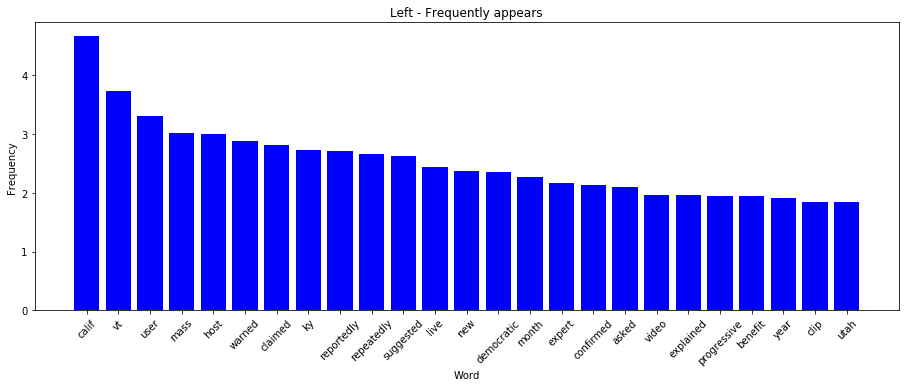

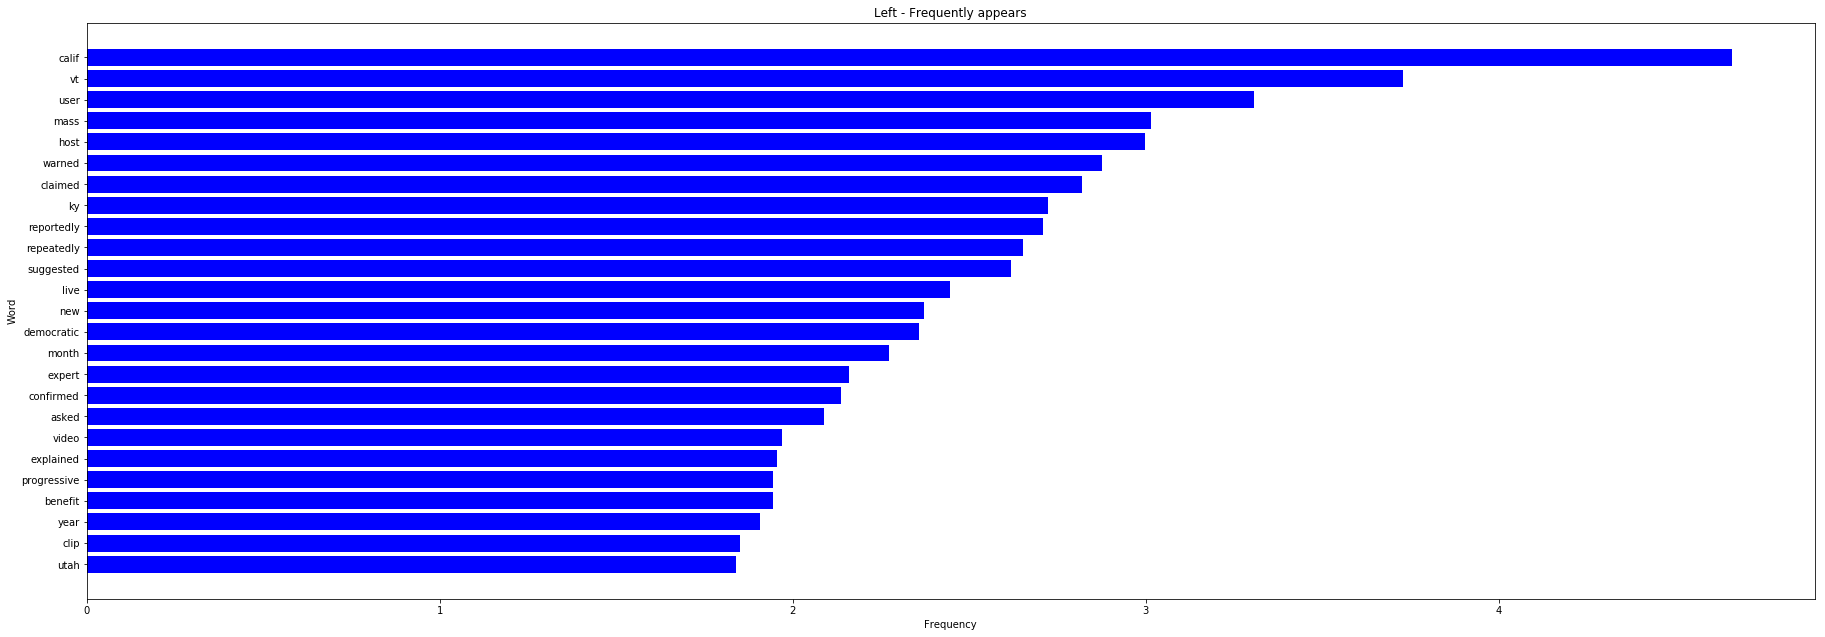

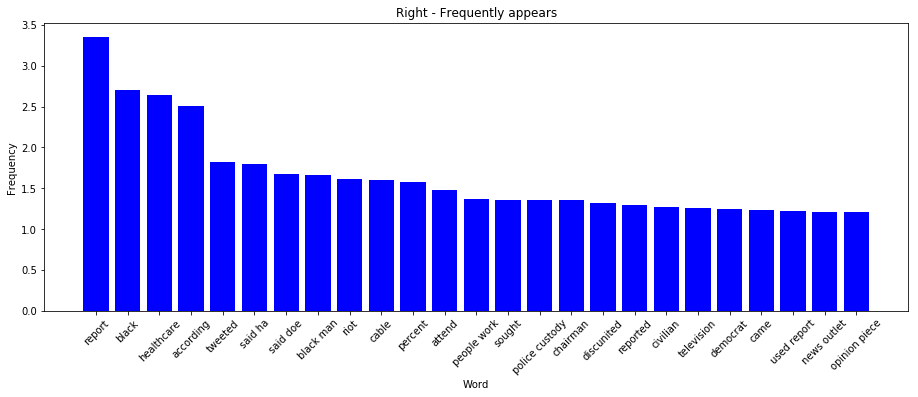

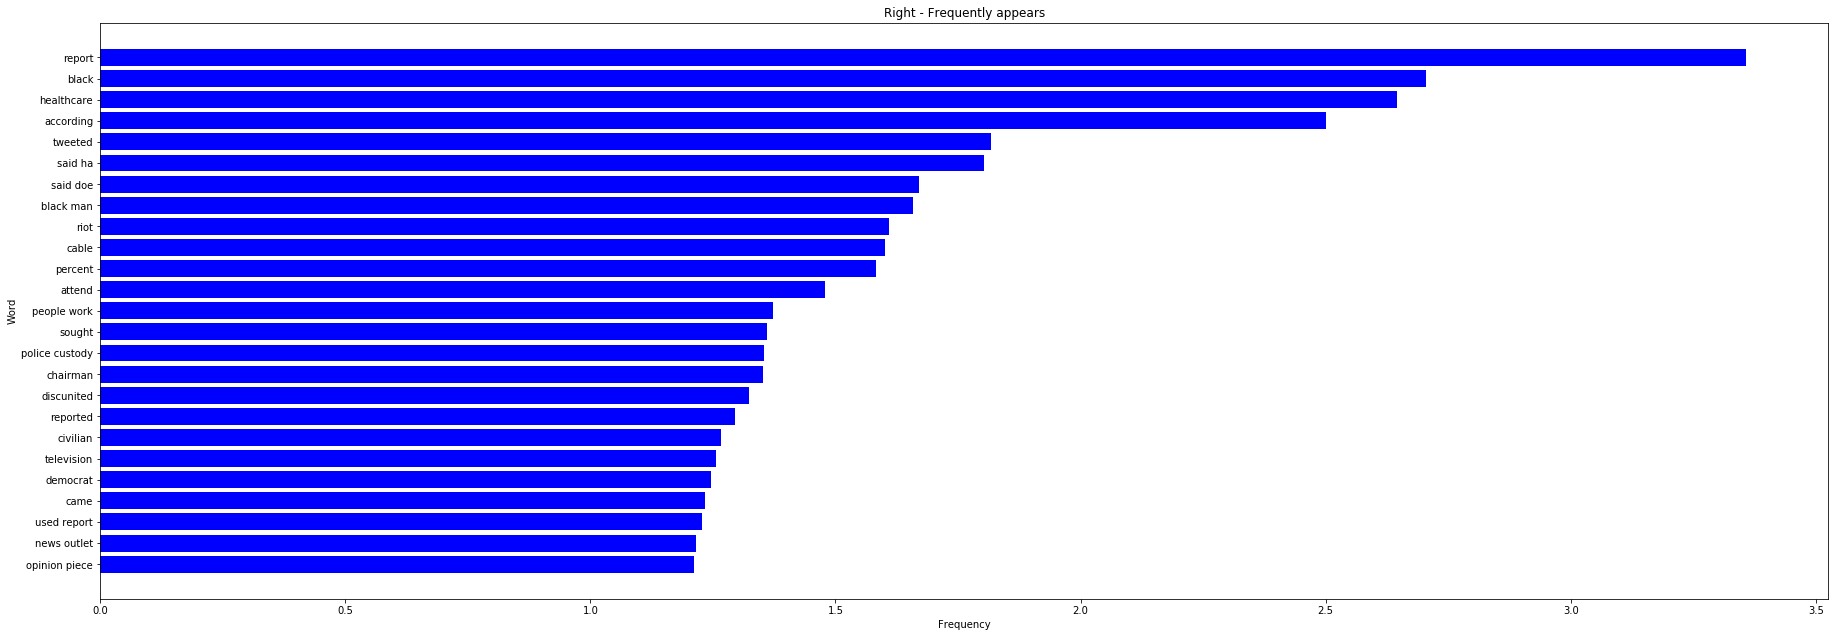

In [115]:
# Plot the most frequently occurring words seen in text labelled as right or left
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def plot_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.bar(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Left - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.barh(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Left - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.bar(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Right - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.barh(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Right - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
plot_most_informative_features(count_vect, clf, 25)

In [116]:
#print(count_vect.get_feature_names())

In [117]:
# Let's save our model
#joblib.dump(text_clf, 'pipeline.pkl')

Confusion Matrix:
[[4012  292]
 [ 362 3942]]
Accuracy Score : 0.9240241635687733
Report : 
              precision    recall  f1-score   support

       Right       0.92      0.93      0.92      4304
        Left       0.93      0.92      0.92      4304

    accuracy                           0.92      8608
   macro avg       0.92      0.92      0.92      8608
weighted avg       0.92      0.92      0.92      8608

             Confusion Matrix


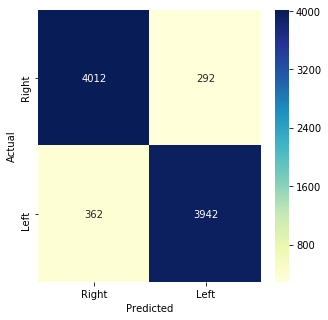

Classification Error of: 0.07597583643122677
95% Confidence Interval of: [0.07037846210631966, 0.08157321075613387]
Left = 0, Right = 1 

Predicted: 0 Actual: 0
Early Voting Means 2020 Primary Is Already Here For Millions Many of the 14 Super Tuesday states will offer some form of early voting, testing the organizational strength of the Democratic White House hopefuls. SACRAMENTO, Calif. (AP) — The Iowa caucuses are more than a week away, but millions of Americans are already free to vote. Early voting in the crush of Super Tuesday states that hold primaries on March 3 amounts to a parallel campaign for the Democratic nomination. While much of the focus is on who will come out on top in the traditional first four voting states, early voting will allow a much broader swath of voters to play a key role in picking the nominee. In Minnesota, in-person early voting began Jan. 17. Vermont’s deadline to mail out its absentee ballots was the same day. Many of the 14 Super Tuesday states will o

In [118]:
# End Results - Load the model and let's see the end results
text_clf = joblib.load('h_and_n_onegram_sr_nol_pr.pkl')
predicted = text_clf.predict(all_data.unfiltered_articles)
#print(metrics.classification_report(test.pole, predicted, target_names=["NotSpam", "Spam"]))
tn, fp, fn, tp = metrics.confusion_matrix(all_data.pole, predicted).ravel()
results = metrics.confusion_matrix(all_data.pole, predicted)
#print((tn, fp, fn, tp))
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', metrics.accuracy_score(all_data.pole, predicted))
print('Report : ')
print(metrics.classification_report(all_data.pole, predicted, target_names=["Right", "Left"]))


print("             Confusion Matrix")
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(results, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=["Right","Left"], yticklabels=["Right","Left"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Error
incorrect_predictions = fp + fn
total_predictions = tp + tn + fp + fn
classification_error = incorrect_predictions / total_predictions
print("Classification Error of:",classification_error)

# 95% Confidence Interval (const: 1.96)
# There is a 95% likelihood that the confidence interval [0.xx, 0.xx] 
# covers the true classification error of the model on unseen data.
confidence_interval = []
confidence_interval.append(classification_error - 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
confidence_interval.append(classification_error + 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
print("95% Confidence Interval of:",confidence_interval)

# Let's see some examples of how the model and original dataset is classifying text.
print("Left = 0, Right = 1 \n")
for x in range(5):
    print("Predicted:", predicted[x], end=" ")
    print("Actual:", all_data['pole'][x])
    print(all_data['unfiltered_articles'][x], end="\n\n")

print("Highest performing classifier:", text_clf)

In [119]:
# Write results to results.txt for the entire notebook's run.
acc = metrics.accuracy_score(all_data.pole, predicted)
acc = "Entire dataset accuracy: " + str(acc) + "\n"
f = open('results.txt', 'a+')
f.write(acc)
f.close()

In [127]:
for model, acc in final_model:
    print(acc)

0.7224738675958187
0.8009291521486642
0.7908246225319395
0.8065427797135114
0.7096399535423927
0.7468060394889664
0.7930507162214477
0.8121370499419281


In [128]:
for x in range(len(final_model)):
    print(final_model[x])

[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=0))]), 0.7224738675958187]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))]), 0.8009291521486642]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0)))]), 0.7908246225319395]
[Pipeline(steps=[('vect',
   

In [130]:
print(text_clf)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])
